## 2.0 Capstone Project Two: All State Purchase Prediction - Exploratory Data Analysis <a id='2_Exploratory_Data_Analysis'></a>
**Submitted By:** Amit Kukreja

## 2.1 Contents<a id='2.1_Contents'></a>
* [2 All State Purchase Prediction - Exploratory Data Analysis](#2_Exploratory_Data_Analysis)

  * [2.1 Contents](#2.1_Contents)

  * [2.2 EDA Objectives](#2.2_EDA_Objectives)

  * [2.3 A Quick Look at Test Data](#2.3_Test_Data)

  * [2.4 Dealing with Categorical & Day/Time Variables](#2.3_Categorical_Variables)
      * [2.4.1 State](#2.4.1_State)
      * [2.4.2 Location](#2.4.2_Location)
      * [2.4.3 Day](#2.4.3_Day)
      * [2.4.4 Time](#2.4.4_Time)
      * [2.4.5 Car Value](#2.4.5_Car_Value)
      * [2.4.6 Risk Factor](#2.4.6_Risk_Factor)
      * [2.4.7 C_Previous](#2.4.7_C_Previous)
      * [2.4.8 Group_Size](#2.4.8_Group_Size)
      * [2.4.9 Categorical variables - conclusion](#2.4.9_Categorical_variables_conclusion)          
  
  * [2.5 Numerical Variables](#2.5_Numerical_Variables)
      * [2.5.1 shopping_pt](#2.5.1_shopping_pt)
      * [2.5.2 Other numerical variables](#2.5.2_Other_numerical_variables)
      * [2.5.3 Numerical variables conclusion](#2.5.3_Numerical_variables_conclusion)
      
  * [2.6 Product Vectors: Understanding how customers change them](#2.6_Product_Vectors)

  * [2.7 Summary](#2.7_Summary)
  

## 2.2 EDA Objectives<a id='2.2_EDA_Objectives'></a>

1) Look at characteristics of all variables and decide which one should be retained for model development.

2) Understand the dynamics of product vectors:
 * How are product vector choices distributed, at the start of shopping journey and at the final purchase.
 * Understand how and when customers change product vectors, specifically:
                * Distribution of changes by quote
                * Distribution of changes by product vector
 * For people with long shopping history (e.g. more than 10 codes), the Cramers V correlation between each code and the final code 
        
3) Understand the co-relations between customer data and product vectors.

4) Modelling Approach : Given varying levels of shopping history for different customers, think through how much history should be used for model development. There are different approaches possible:

 * Multiple models developed for varying levels of customer history e.g. A model for 2 shopping quotes, another one for 3 shopping quotes and so on. 

 * A generic model that perhaps considers the last 2 quotes i.e. quote n and quote n-1 or the first 2 quotes.

 * A generic model that consider the first and last quotes i.e. quote n and quote 1
    
Generic models would have more observations to learn from, as for all customers 2 quotes are available. On the other hand, specific models would have the ability to analyse more information for each customer e.g. all possible values for a certain product vector that the customer has experimented with. This may help improve the final prediction. At this stage, let's keep all options open and find a optimal approach during the EDA phase.
        
5) Write up draft EDA report in google doc 
  * Choose 3-10 charts from the analysis, and write brief explanation of why they are meaningful. 
  *       * univariate
                * Bivariate charts
                * Correlation matrix
                * Feature importances
  * Along with the explanation, you can also add in your statistical testing here but it will be brief  


In [1]:
from pathlib import Path

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sb_utils import save_file
from collections import defaultdict
from collections import Counter


In [2]:
df_train = pd.read_csv("WIP_data/training_data.csv")

df_train.head()


,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,C_previous_13,duration_previous_13,A_13,B_13,C_13,D_13,E_13,F_13,G_13,cost_13
0,10109793,9,1,4,14:44,CO,13320,1,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10002231,8,1,5,13:36,OH,10601,1,0,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10150024,8,1,4,15:33,OH,10081,3,1,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10003949,8,1,4,09:13,FL,10302,2,1,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10103809,10,1,2,11:06,FL,14844,1,1,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_train.shape

(77607, 259)

## 2.3 A Quick look at Test Data<a id='2.3_Test_Data'></a>

Let's look at the test data that All State provided. We shall not be using this test data, as we do not know the final outcomes i.e. product vectors. Instead, the test data would be extracted from the training data itself.

However, it would be useful to understand some broad characteristics of the test data that the model would encounter in the real world.


In [2]:
test_data = pd.read_csv("Raw_data/test_v2.csv")

test_data.head()

,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
0,10000001,1,0,1,12:35,OK,10002.0,1,0,9,...,3.0,9.0,0,0,1,1,0,0,4,543
1,10000001,2,0,1,12:36,OK,10002.0,1,0,9,...,3.0,9.0,2,1,1,3,1,3,2,611
2,10000002,1,0,4,12:19,PA,10003.0,1,1,7,...,2.0,15.0,2,0,2,3,1,2,2,691
3,10000002,2,0,4,12:21,PA,10003.0,1,1,7,...,2.0,15.0,2,0,2,3,1,2,2,695
4,10000003,1,0,3,17:12,AR,10004.0,1,0,4,...,3.0,1.0,1,0,1,1,0,2,2,628


In [3]:
# Let's check for how many customers data is provided in the test set
test_data["customer_ID"].nunique()

55716

In [4]:
# Now's let's check the shopping_pt column to see how much history is available for these customers 

no_of_cust_by_shpng_pt = pd.DataFrame(test_data.groupby("shopping_pt")["customer_ID"].nunique())
no_of_cust_by_shpng_pt.columns = ["#Customers"]
no_of_cust_by_shpng_pt["%_of_Customers"] = no_of_cust_by_shpng_pt["#Customers"] *100/ no_of_cust_by_shpng_pt["#Customers"].max()
no_of_cust_by_shpng_pt

,#Customers,%_of_Customers
shopping_pt,,
1,55716,100.000000
2,55716,100.000000
3,36773,66.000790
4,23475,42.133319
5,14224,25.529471
6,7696,13.812908
7,3493,6.269294
8,1318,2.365568
9,359,0.644339


In [6]:
np.around(np.average(test_data.groupby("customer_ID")["shopping_pt"].max()), 2)

3.57

So for all customers atleast 2 shopping quotes are provided. This then drops rapidly. For only ~14% customers, 6 quotes are available. On an average 3 to 4 quotes are available for a customer. This has implications for model development and training which we shall discuss in subsequent sections.

In [7]:
test_data.isna().sum()

customer_ID              0
shopping_pt              0
record_type              0
day                      0
time                     0
state                    0
location               678
group_size               0
homeowner                0
car_age                  0
car_value              739
risk_factor          75487
age_oldest               0
age_youngest             0
married_couple           0
C_previous            9769
duration_previous     9769
A                        0
B                        0
C                        0
D                        0
E                        0
F                        0
G                        0
cost                     0
dtype: int64

So the test data has large missing values for risk_factor, C_previous and duration_previous. We tackled this at the data wrangling stage for the training data by deploying appropriate imputation strategy for each of the features. 

## 2.4 Categorical and Date/Time Variables
In this section we shall decide

1) what to do with categorical variables like state, location etc. Should we keep them or remove them?

2) What to do with time variable ? Does time gap between two successive quotes impact the quantum of changes made by a customer ?

3) How to handle day variable. It is currently encoded numerically from 0-6, but this encoding doesn't reflect 'time_gap' correctly. E.g The 'time_gap' between a Monday and Sunday is 1 day, but the current encoding separates them by 6, as Monday is encoded 0 and Sunday is encoded 6. Also, as dates are not provided, there is no way to know the no. of days separating customer shopping instances. E.g. say in a customer's shopping history, day column shows 1 (Tuesday) for certain quotes and 3(Thursday) for some other quotes. There is no way to know whether the Thursday was in the same week or the any subsequent week. For this reason, it is also difficult to estimate time_gap between quotes on two separate days.

## 2.4.1 State<a id='2.4.1_State'></a>

Let's start by looking at state and understanding what kind of interactions they have with the final product vectors.


In [11]:
#Let's check the distribution of customers by state

plt.style.use('fivethirtyeight')

state_dist = pd.DataFrame(df_train.groupby("state")["customer_ID"].nunique().sort_values(ascending=False))

state_dist.columns = ["#Customers"]

state_dist['%_of_Customers'] = np.around((state_dist["#Customers"] *100 / state_dist["#Customers"].sum()), 2)

state_dist

,#Customers,%_of_Customers
state,,
FL,11660,15.02
NY,10923,14.07
PA,7135,9.19
OH,5393,6.95
MD,3369,4.34
IN,3010,3.88
AL,2866,3.69
WA,2850,3.67
CO,2835,3.65


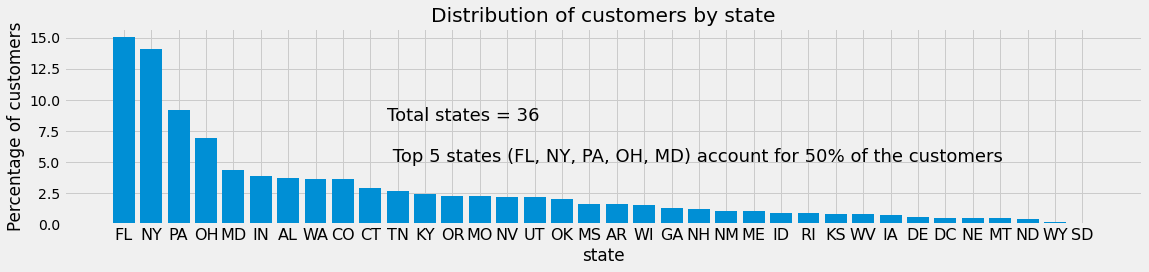

In [37]:
fig, ax = plt.subplots(1,1, figsize=(16,4))
plt.bar(state_dist.index, state_dist['%_of_Customers'])
#plt.axvline(6.86, linestyle="--", c='black')
#plt.annotate('Avg. No. of quotes = 6.86', xy=(6.86,15),  xycoords='data', xytext=(0.85, 0.9), textcoords='axes fraction', \
  #          arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='center', verticalalignment='top')

plt.annotate('Total states = 36\n\n Top 5 states (FL, NY, PA, OH, MD) account for 50% of the customers', xy=(10,10),  \
    xycoords='data', xytext=(0.3, 0.6), textcoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=18)

plt.xlabel('state')
plt.ylabel('Percentage of customers')
plt.xticks(fontsize=16)
plt.title("Distribution of customers by state")
plt.tight_layout()
plt.show()
fig.savefig('charts_EDA/Chart_1_customer_distribution_by_state.jpg')


In [13]:
# To understand whether state makes an impact on the product vectors, let's check the distribution of a couple of product
# vectors across states. Let's check product vector B as it has only two values - 0 and 1.
# We define vector_b_ratio which is the % of customers selecting 1 for vector B

vector_b_ratio = df_train.pivot_table(values = "B", index = "state")

state_dist = state_dist.merge(vector_b_ratio, on="state")

state_dist.sort_values(by="B")

,#Customers,B
state,,
ND,317,0.097792
CT,2267,0.214380
ME,800,0.215000
RI,688,0.255814
NM,801,0.343321
OK,1603,0.346850
NH,920,0.357609
SD,66,0.363636
PA,7135,0.383041


The above table provides the ratio of customers in a particular state who chose the value 1 for vector B. 
We can see that it ranges from ~10% for North Dakota to as high as 73% for Tennessee. Florida, the state with most no. of 
customers is at 47%. 

At first sight this seems like a large variation. But this could just be the effect of random sampling.
Let's use the Pearson's chi-squared test to determine whether there is a statistically significant difference between 
different state's selection of the B vector.

In [17]:


alpha = 0.05
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_train['state'], df_train['B']))
print(f"The p_value for chi_squared test between state & B vector = {p} ")


The p_value for chi_squared test between state & B vector = 0.0 


The above chi-squared test gives a p-value of 0.0, suggesting that state and B vector are not independent. Let's perform the chi-squared test for state on a couple of other product vectors as well.

In [24]:
from scipy.stats import chi2_contingency
vectors = ['A', 'B', 'G']
for vector in vectors:
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_train['state'], df_train[vector]))
    print(f"The p_value for chi_squared test between state & {vector} vector = {p}")

The p_value for chi_squared test between state & A vector = 0.0
The p_value for chi_squared test between state & B vector = 0.0
The p_value for chi_squared test between state & G vector = 0.0


The above results suggest that state and vector selections are not independent. So we shall keep state as a feature in our feature matrix.

## 2.4.2 Location<a id='2.4.2_Location'></a>

In [28]:
location_dist = pd.DataFrame(df_train.groupby("location")["customer_ID"].nunique().sort_values(ascending=False))

location_dist.columns = ["#Customers"]
location_dist['%_of_Customers'] = np.around((location_dist["#Customers"] *100 / location_dist["#Customers"].sum()), 2)

location_dist.head()


,#Customers,%_of_Customers
location,,
10083,113,0.15
10348,106,0.14
11196,99,0.13
10213,95,0.12
11517,93,0.12


In [31]:
location_dist[location_dist["#Customers"] < 30 ].shape[0] 

5633

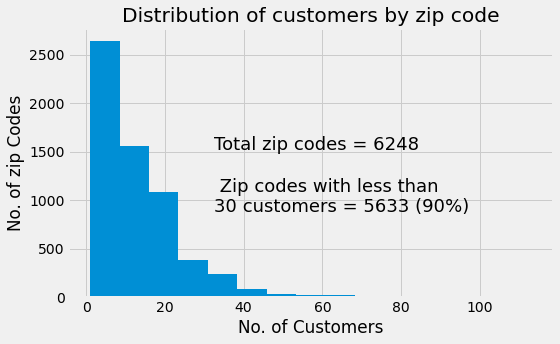

In [39]:
plt.style.use("fivethirtyeight")

fig, ax = plt.subplots(1,1, figsize=(8,5))

plt.hist(location_dist['#Customers'], bins = 15)
plt.annotate('Total zip codes = 6248\n\n Zip codes with less than \n30 customers = 5633 (90%)', xy=(10,10),  \
    xycoords='data', xytext=(0.3, 0.6), textcoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=18)

plt.xlabel('No. of Customers')
plt.ylabel('No. of zip Codes')
plt.title("Distribution of customers by zip code")
plt.tight_layout()
plt.show()
fig.savefig('charts_EDA/Chart_2_customer_distribution_by_location.jpg')

The above histogram shows that a large majority of pin codes have less than 20 customers. There are more than 6000 pin codes in the dataset. For a model to learn something from this variable when more than 95% have less than 20 customers would add too much complexity and very little value. As such we shall drop location from the set of features for model development.

## 2.4.3 Day<a id='2.4.3_Day'></a>


Let's look at the day variable to understand how they are distributed and whether they have an impact on product vectors.

In [30]:
day_dist = pd.DataFrame(df_train.groupby("day")["customer_ID"].nunique().sort_values(ascending=False))

day_dist.columns = ["#Customers"]
day_dist['%_customers'] = np.around(day_dist["#Customers"]*100/ df_train.shape[0],2)
day_dist


,#Customers,%_customers
day,,
4,16733,21.56
1,15319,19.74
2,15114,19.48
0,14894,19.19
3,14320,18.45
5,1139,1.47
6,88,0.11


Clearly, most customers buy policies on weekdays with Friday (4) being the heaviest. Let us use the chi-squared test to check if vector selections have anything dependence on day of purchase.
For this test, we shall consider only weekdays, since weekends have literally very low purchases.


In [34]:
df_train_weekdays = df_train[df_train['day'] <=4]

vectors = ['A', 'B', 'C','D','E','F','G']

for vector in vectors:
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_train_weekdays['day'], df_train_weekdays[vector]))
    print(f"The p_value for chi_squared test between day of the week & {vector} vector = {p}")

The p_value for chi_squared test between day of the week & A vector = 0.21786524359335932
The p_value for chi_squared test between day of the week & B vector = 0.009469929259496107
The p_value for chi_squared test between day of the week & C vector = 0.00013494120712344255
The p_value for chi_squared test between day of the week & D vector = 4.0042238596048884e-05
The p_value for chi_squared test between day of the week & E vector = 0.007172961087697244
The p_value for chi_squared test between day of the week & F vector = 0.06383441236075768
The p_value for chi_squared test between day of the week & G vector = 0.012240917566838089


The p_values for the chi_squared are a mixed bag:
 * For vectors A and F, p-values are above 0.05, suggesting that day and vector selection are independent. 
 * For the other vectors, the p_values are lower than 0.05, suggesting that day and vector selection are dependent. 
 
Let's check the day-wise distribution for vectors B and C where p-value is less than 0.05.

In [75]:
df_train_weekdays['C'].value_counts()

3    29922
1    22755
2    16010
4     7693
Name: C, dtype: int64

In [74]:
vectB_by_day = pd.crosstab(df_train_weekdays['day'], df_train_weekdays['B'])
vectB_by_day['total'] = vectB_by_day.sum(axis=1)
vectB_by_day['B0_%'] = np.around(vectB_by_day[0] *100 / vectB_by_day['total'],2)
vectB_by_day['B1_%'] = np.around(vectB_by_day[1] *100 / vectB_by_day['total'],2)

vectB_by_day

B,0,1,total,B0_%,B1_%
day,,,,,
0,7930,6964,14894,53.24,46.76
1,7862,7457,15319,51.32,48.68
2,7840,7274,15114,51.87,48.13
3,7545,6775,14320,52.69,47.31
4,8784,7949,16733,52.50,47.50


To the naked eye, the above differences in Vector B selection don't seem very different. Let's check for vector C.

In [77]:
vectC_by_day = pd.crosstab(df_train_weekdays['day'], df_train_weekdays['C'])
vectC_by_day['total'] = vectC_by_day.sum(axis=1)
vectC_by_day['C1_%'] = np.around(vectC_by_day[1] *100 / vectC_by_day['total'],2)
vectC_by_day['C2_%'] = np.around(vectC_by_day[2] *100 / vectC_by_day['total'],2)
vectC_by_day['C3_%'] = np.around(vectC_by_day[3] *100 / vectC_by_day['total'],2)
vectC_by_day['C4_%'] = np.around(vectC_by_day[4] *100 / vectC_by_day['total'],2)

vectC_by_day

C,1,2,3,4,total,C1_%,C2_%,C3_%,C4_%
day,,,,,,,,,
0,4348,3151,5849,1546,14894,29.19,21.16,39.27,10.38
1,4478,3165,6105,1571,15319,29.23,20.66,39.85,10.26
2,4448,3159,5968,1539,15114,29.43,20.90,39.49,10.18
3,4264,2971,5592,1493,14320,29.78,20.75,39.05,10.43
4,5217,3564,6408,1544,16733,31.18,21.30,38.30,9.23


Again, the above differences in Vector C selection don't seem very different. Let's check for one more vector, vector G.


In [79]:
vectG_by_day = pd.crosstab(df_train_weekdays['day'], df_train_weekdays['G'])
vectG_by_day['total'] = vectG_by_day.sum(axis=1)
vectG_by_day['G1_%'] = np.around(vectG_by_day[1] *100 / vectG_by_day['total'],2)
vectG_by_day['G2_%'] = np.around(vectG_by_day[2] *100 / vectG_by_day['total'],2)
vectG_by_day['G3_%'] = np.around(vectG_by_day[3] *100 / vectG_by_day['total'],2)
vectG_by_day['G4_%'] = np.around(vectG_by_day[4] *100 / vectG_by_day['total'],2)

vectG_by_day

G,1,2,3,4,total,G1_%,G2_%,G3_%,G4_%
day,,,,,,,,,
0,2952,5900,4780,1262,14894,19.82,39.61,32.09,8.47
1,3170,5913,4879,1357,15319,20.69,38.60,31.85,8.86
2,3138,5780,4866,1330,15114,20.76,38.24,32.20,8.80
3,3017,5604,4465,1234,14320,21.07,39.13,31.18,8.62
4,3515,6591,5299,1328,16733,21.01,39.39,31.67,7.94


By visually inspecting vector selection differences among days, there seems to be no significant difference. As such, we shall exclude day as a feature in the model building.

## 2.4.4 Time<a id='2.4.4_Time'></a>


A look at the time variable indicates there are 1204 different values, almost 1 for each minute in the day! 
So let us split this in 4 different day parts - morning, day, evening and night. We can then see if a day part impact vector choice.

While time_gap could be an indicator of possibility of change in vector, for reasons discussed earlier, it is not possible to calculate time_gap for two successive quotes on different days, as 'date' is not available.


In [40]:

def day_part(hr):
    
    if hr >= 5 and hr < 10:
        return 'morning'
    elif hr >= 10 and hr < 17:
        return 'day'
    elif hr >= 17 and hr < 21:
        return 'evening'
    else:
        return 'night'

df_train['hour'] = df_train['time'].map(lambda x:  x.split(':')[0]).astype('uint8')
df_train['day_part'] = df_train['hour'].apply(day_part)


In [41]:
df_train['day_part'].value_counts()

day        60315
morning     9181
evening     7866
night        245
Name: day_part, dtype: int64

We see above that most people buy the policy during day time between 10am and 5pm and very few people buy the policy after 9pm. As such, we shall consider only three day parts - morning, day and evening to check if that has any impact on vector selection. 

In [57]:
df_temp = df_train[df_train['day_part'].isin(['day', 'morning', 'evening'])]

vectors = ['A', 'B', 'C','D','E','F','G']

for vector in vectors:
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_temp['day_part'], df_temp[vector]))
    print(f"The p_value for chi_squared test between day_part & {vector} vector = {p}")

The p_value for chi_squared test between day_part & A vector = 3.094774240720547e-36
The p_value for chi_squared test between day_part & B vector = 5.597515185402544e-21
The p_value for chi_squared test between day_part & C vector = 7.843854987609997e-21
The p_value for chi_squared test between day_part & D vector = 4.779165675307236e-18
The p_value for chi_squared test between day_part & E vector = 7.763447557712257e-26
The p_value for chi_squared test between day_part & F vector = 8.822746138846568e-78
The p_value for chi_squared test between day_part & G vector = 2.2813017244557344e-56


The above p_values are all extremely low, suggesting dependence of vectors and day_part when policy is purchased. Let's check how vector B selection differe by day_part. 

In [73]:
vectB_by_day_part = pd.crosstab(df_temp['day_part'], df_temp['B'])
vectB_by_day_part['total'] = vectB_by_day_part.sum(axis=1)
vectB_by_day_part['B0_%'] = np.around(vectB_by_day_part[0] *100 / vectB_by_day_part['total'],2)
vectB_by_day_part['B1_%'] = np.around(vectB_by_day_part[1] *100 / vectB_by_day_part['total'],2)

vectB_by_day_part

B,0,1,total,B0_%,B1_%
day_part,,,,,
day,31677,28638,60315,52.52,47.48
evening,3758,4108,7866,47.78,52.22
morning,5053,4128,9181,55.04,44.96


We see above that customers buying in the morning are more likely to select a value of B as 0, while those buying in the evening are more likely to select B as 1. Let's check for vector G that has 4 options to choose from.

In [72]:
vectG_by_day_part = pd.crosstab(df_temp['day_part'], df_temp['G'])
vectG_by_day_part['total'] = vectG_by_day_part.sum(axis=1)
vectG_by_day_part['G1_%'] = np.around(vectG_by_day_part[1] *100 / vectG_by_day_part['total'],2)
vectG_by_day_part['G2_%'] = np.around(vectG_by_day_part[2] *100 / vectG_by_day_part['total'],2)
vectG_by_day_part['G3_%'] = np.around(vectG_by_day_part[3] *100 / vectG_by_day_part['total'],2)
vectG_by_day_part['G4_%'] = np.around(vectG_by_day_part[4] *100 / vectG_by_day_part['total'],2)

vectG_by_day_part

G,1,2,3,4,total,G1_%,G2_%,G3_%,G4_%
day_part,,,,,,,,,
day,12358,23670,19142,5145,60315,20.49,39.24,31.74,8.53
evening,2033,3088,2261,484,7866,25.85,39.26,28.74,6.15
morning,1637,3426,3184,934,9181,17.83,37.32,34.68,10.17


Again we notice that there are noticeable difference in selection of G1, G3 & G4 between morning and evening customers. 
So we will keep day_part as a feature.


## 2.4.5 Car Value<a id='2.4.5_Car_Value'></a>

     
In the data wrangling stage, car value values of 'a' to 'g' were changed to numerical values 1-9, as analysis of car_value vs policy cost suggested an increasing trend of cost from 'a' to 'g'. 

In [80]:
df_train['car_value'].value_counts()

5    25779
6    20611
4    13155
7    11539
8     3362
3     2450
9      406
2      169
1      136
Name: car_value, dtype: int64

In [83]:
df_temp = df_train[df_train['car_value'].isin([3,4,5,6,7,8])]

vectors = ['A', 'B', 'C','D','E','F','G']

for vector in vectors:
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_temp['car_value'], df_temp[vector]))
    print(f"The p_value for chi_squared test between car_value & {vector} vector = {p}")

The p_value for chi_squared test between car_value & A vector = 0.0
The p_value for chi_squared test between car_value & B vector = 6.7082278080213974e-40
The p_value for chi_squared test between car_value & C vector = 0.0
The p_value for chi_squared test between car_value & D vector = 9.83215883192617e-156
The p_value for chi_squared test between car_value & E vector = 1.1255451239055601e-291
The p_value for chi_squared test between car_value & F vector = 1.253863318157966e-271
The p_value for chi_squared test between car_value & G vector = 1.2625294541983036e-49


In [86]:

vectG_by_car_value = pd.crosstab(df_temp['car_value'], df_temp[vector])
vectG_by_car_value['total'] = vectG_by_car_value.sum(axis=1)
vectG_by_car_value['G1_%'] = np.around(vectG_by_car_value[1] *100 / vectG_by_car_value['total'],2)
vectG_by_car_value['G2_%'] = np.around(vectG_by_car_value[2] *100 / vectG_by_car_value['total'],2)
vectG_by_car_value['G3_%'] = np.around(vectG_by_car_value[3] *100 / vectG_by_car_value['total'],2)
vectG_by_car_value['G4_%'] = np.around(vectG_by_car_value[4] *100 / vectG_by_car_value['total'],2)

vectG_by_car_value

G,1,2,3,4,total,G1_%,G2_%,G3_%,G4_%
car_value,,,,,,,,,
3,525,1134,673,118,2450,21.43,46.29,27.47,4.82
4,2873,5254,4100,928,13155,21.84,39.94,31.17,7.05
5,5543,10032,8199,2005,25779,21.50,38.92,31.80,7.78
6,4181,7895,6597,1938,20611,20.29,38.30,32.01,9.40
7,2231,4385,3742,1181,11539,19.33,38.00,32.43,10.23
8,626,1239,1129,368,3362,18.62,36.85,33.58,10.95


In [87]:
vectB_by_car_value = pd.crosstab(df_temp['car_value'], df_temp['B'])
vectB_by_car_value['total'] = vectB_by_car_value.sum(axis=1)
vectB_by_car_value['B0_%'] = np.around(vectB_by_car_value[0] *100 / vectB_by_car_value['total'],2)
vectB_by_car_value['B1_%'] = np.around(vectB_by_car_value[1] *100 / vectB_by_car_value['total'],2)

vectB_by_car_value

B,0,1,total,B0_%,B1_%
car_value,,,,,
3,1511,939,2450,61.67,38.33
4,7283,5872,13155,55.36,44.64
5,13480,12299,25779,52.29,47.71
6,10493,10118,20611,50.91,49.09
7,5741,5798,11539,49.75,50.25
8,1658,1704,3362,49.32,50.68


The p-values for chi-squared test as well as visual inspection of car_value vs product vector selections suggest that there are diffferences in product vector selection based on car value. So we shall retain car_value as a feature. 

## 2.4.6 Risk Factor<a id='2.4.6_Risk_Factor'></a>
    
This is an ordinal assessment of the customer by All State. There were almost 35% missing values that were imputed as 0. Let's apply the ch-squared test to see whether risk_factor is related with product vectors. 

In [88]:
df_train['risk_factor'].value_counts()

0    26873
3    14070
4    13262
1    11917
2    11485
Name: risk_factor, dtype: int64

In [96]:

vectors = ['A', 'B', 'C','D','E','F','G']

for vector in vectors:
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_train['risk_factor'], df_train[vector]))
    print(f"The p_value for chi_squared test between risk_factor & {vector} vector = {p}")

The p_value for chi_squared test between risk_factor & A vector = 0.0
The p_value for chi_squared test between risk_factor & B vector = 1.062777758261221e-07
The p_value for chi_squared test between risk_factor & C vector = 0.0
The p_value for chi_squared test between risk_factor & D vector = 0.0
The p_value for chi_squared test between risk_factor & E vector = 0.0
The p_value for chi_squared test between risk_factor & F vector = 4.3639250729379926e-300
The p_value for chi_squared test between risk_factor & G vector = 0.0


In [90]:
vectB_by_risk_factor = pd.crosstab(df_train['risk_factor'], df_train['B'])
vectB_by_risk_factor['total'] = vectB_by_risk_factor.sum(axis=1)
vectB_by_risk_factor['B0_%'] = np.around(vectB_by_risk_factor[0] *100 / vectB_by_risk_factor['total'],2)
vectB_by_risk_factor['B1_%'] = np.around(vectB_by_risk_factor[1] *100 / vectB_by_risk_factor['total'],2)

vectB_by_risk_factor

B,0,1,total,B0_%,B1_%
risk_factor,,,,,
0,14364,12509,26873,53.45,46.55
1,6005,5912,11917,50.39,49.61
2,5980,5505,11485,52.07,47.93
3,7435,6635,14070,52.84,47.16
4,6814,6448,13262,51.38,48.62


In [91]:
vectG_by_risk_factor = pd.crosstab(df_train['risk_factor'], df_train['G'])
vectG_by_risk_factor['total'] = vectG_by_risk_factor.sum(axis=1)
vectG_by_risk_factor['G1_%'] = np.around(vectG_by_risk_factor[1] *100 / vectG_by_risk_factor['total'],2)
vectG_by_risk_factor['G2_%'] = np.around(vectG_by_risk_factor[2] *100 / vectG_by_risk_factor['total'],2)
vectG_by_risk_factor['G3_%'] = np.around(vectG_by_risk_factor[3] *100 / vectG_by_risk_factor['total'],2)
vectG_by_risk_factor['G4_%'] = np.around(vectG_by_risk_factor[4] *100 / vectG_by_risk_factor['total'],2)

vectG_by_risk_factor

G,1,2,3,4,total,G1_%,G2_%,G3_%,G4_%
risk_factor,,,,,,,,,
0,7851,11478,6376,1168,26873,29.22,42.71,23.73,4.35
1,976,3600,5259,2082,11917,8.19,30.21,44.13,17.47
2,1538,4175,4461,1311,11485,13.39,36.35,38.84,11.41
3,2684,5430,4839,1117,14070,19.08,38.59,34.39,7.94
4,3057,5575,3721,909,13262,23.05,42.04,28.06,6.85


Vector G above has very different selection across different risk_factor values. The p-values for chi-squared test as well as visual inspection of risk_factor vs product vector selections suggest that there are diffferences in product vector selection based on car value. So we shall retain risk_factor as a feature.

## 2.4.7 C_Previous<a id='2.4.7_C_Previous'></a>


Next we look at **C_previous**. This is the current or past value of vector 'C' for a customer. It has a high corelation with product vector C, as the heatmap in the profiling report showed. Let's apply the chi-squared test and see the results.

In [92]:
df_train['C_previous'].value_counts()

3    32986
1    20180
2    13081
4    11360
Name: C_previous, dtype: int64

In [97]:
vectors = ['A', 'B', 'C','D','E','F','G']

for vector in vectors:
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_train['C_previous'], df_train[vector]))
    print(f"The p_value for chi_squared test between C_previous & {vector} vector = {p}")

The p_value for chi_squared test between C_previous & A vector = 0.0
The p_value for chi_squared test between C_previous & B vector = 6.179106669628058e-20
The p_value for chi_squared test between C_previous & C vector = 0.0
The p_value for chi_squared test between C_previous & D vector = 0.0
The p_value for chi_squared test between C_previous & E vector = 7.221624793797921e-243
The p_value for chi_squared test between C_previous & F vector = 1.2811429792334286e-203
The p_value for chi_squared test between C_previous & G vector = 1.0594401082369782e-282


The p-values for chi-squared test suggest that there are diffferences in product vector selection based on C_previous. So we shall retain C_previous as a feature.

## 2.4.8 Group_Size<a id='2.4.8_Group_Size'></a>

In [94]:
df_train['group_size'].value_counts()

1    60548
2    15958
3     1017
4       84
Name: group_size, dtype: int64

In [98]:
vectors = ['A', 'B', 'C','D','E','F','G']

for vector in vectors:
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_train['group_size'], df_train[vector]))
    print(f"The p_value for chi_squared test between group_size & {vector} vector = {p}")

The p_value for chi_squared test between group_size & A vector = 2.956125135866512e-31
The p_value for chi_squared test between group_size & B vector = 5.72256125592646e-10
The p_value for chi_squared test between group_size & C vector = 8.711416702911881e-270
The p_value for chi_squared test between group_size & D vector = 3.896664977523966e-55
The p_value for chi_squared test between group_size & E vector = 3.213253438589052e-20
The p_value for chi_squared test between group_size & F vector = 5.48642238069991e-07
The p_value for chi_squared test between group_size & G vector = 5.778651088223941e-66


The p-values for chi-squared test suggest that there are diffferences in product vector selection based on group_size. So we shall retain group_size as a feature.



## 2.4.9 homeowner and married_couple<a id='2.4.9_homeowner_and_married_couple'></a>


Let's look at the spread and vector interactions of the two booleam variables -  homeowner and married_couple



In [103]:
vectors = ['A', 'B', 'C','D','E','F','G']

for vector in vectors:
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_train['homeowner'], df_train[vector]))
    print(f"The p_value for chi_squared test between homeowner & {vector} vector = {p}")

The p_value for chi_squared test between homeowner & A vector = 9.179938445058858e-239
The p_value for chi_squared test between homeowner & B vector = 1.9031691643615223e-24
The p_value for chi_squared test between homeowner & C vector = 0.0
The p_value for chi_squared test between homeowner & D vector = 9.734426914814125e-285
The p_value for chi_squared test between homeowner & E vector = 9.314673723597243e-162
The p_value for chi_squared test between homeowner & F vector = 6.87329390691397e-91
The p_value for chi_squared test between homeowner & G vector = 2.1953992441594673e-224


In [102]:
vectors = ['A', 'B', 'C','D','E','F','G']

for vector in vectors:
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_train['married_couple'], df_train[vector]))
    print(f"The p_value for chi_squared test between married_couple & {vector} vector = {p}")

The p_value for chi_squared test between married_couple & A vector = 5.753340027935635e-32
The p_value for chi_squared test between married_couple & B vector = 5.911870549072174e-07
The p_value for chi_squared test between married_couple & C vector = 5.795102199401143e-279
The p_value for chi_squared test between married_couple & D vector = 1.070739165681046e-56
The p_value for chi_squared test between married_couple & E vector = 3.504271989322027e-21
The p_value for chi_squared test between married_couple & F vector = 7.061876743515593e-05
The p_value for chi_squared test between married_couple & G vector = 7.383006297336036e-67


The p-values for chi-squared test suggest that there are diffferences in product vector selection based on homeowner and married_couple. So we shall retain these two features.

Finally let's apply check the co-relation between all the categorical variables and the product vectors using the Cramer's V co-relation technique.

In [43]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def cramers_v_df(dataframe):
    cols = dataframe.columns
    crm_v_matrix = {'feature': cols}
    for col1 in cols:
        crm_v_matrix[col1] = []
        for col2 in cols:
            crm_v_matrix[col1].append(round(cramers_v(dataframe[col1], dataframe[col2]),2))
     
    return pd.DataFrame(crm_v_matrix).set_index('feature')

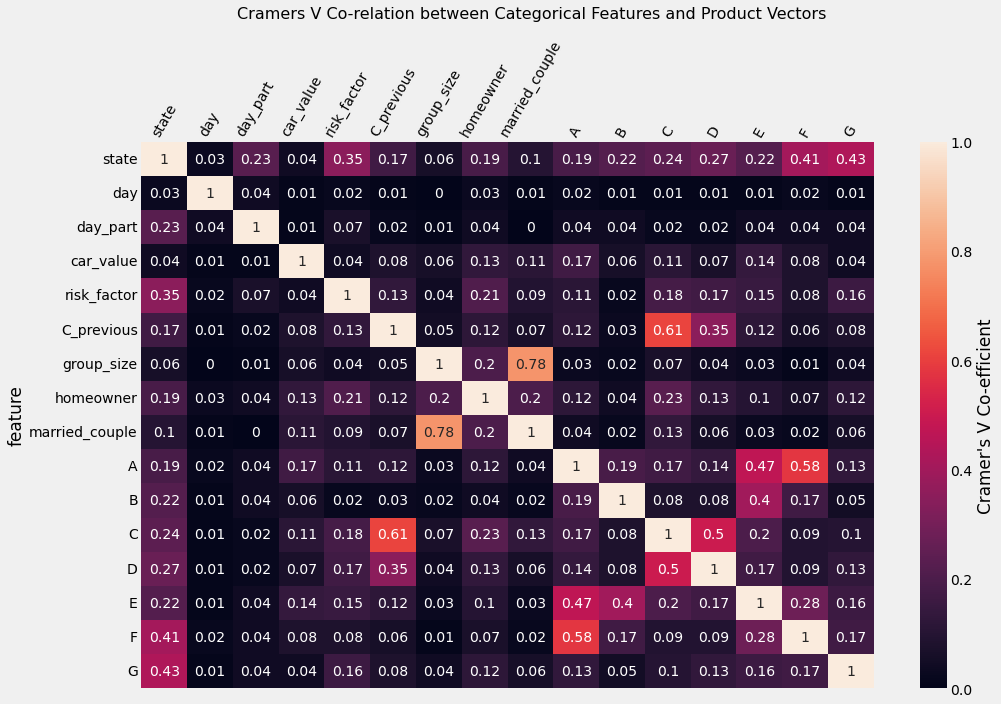

In [88]:
product_vectors = ['A', 'B', 'C','D','E','F','G']
catg_features = ['state', 'day', 'day_part', 'car_value', 'risk_factor', 'C_previous', 'group_size', 'homeowner', 'married_couple']

df_catg_features_and_vectors = df_train[catg_features+product_vectors]

catg_correlations = cramers_v_df(df_catg_features_and_vectors)
    
fig, ax = plt.subplots(figsize=(15,10))
ax=sns.heatmap(catg_correlations, annot=True, cbar_kws={"label": "Cramer's V Co-efficient"})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=60)
plt.suptitle("Cramers V Co-relation between Categorical Features and Product Vectors", fontsize=16)
plt.tight_layout()
plt.show()

fig.savefig('charts_EDA/Chart_3_cramers_V_corelation_with_categorical_variables.jpg')
    

The above heatmap based on Cramer's V co-relation between different categorical features and product vectors shows some noticeable co-relations between:

1) State and vectors F and G

2) C_previous and Vectors C and D

3) Vector A with Vectors E and F

4) Vectors C and D

5) Vectors B and E

We can also notice that certain categorical variables have extremely low co-relations with product vectors. These are:

1) day_part

2) group_size

These two variables can be dropped to avoid adding unnecessary complexity in the modelling.

## 2.4.9 Categorical variables - conclusion<a id='2.4.9_Categorical_variables_conclusion'></a>

After analysing all the categorical and day/time variables, the following variables would be kept in the model:

* State, car_value, C_previous and risk_factor 

5 features that are being **dropped** from the modelling are - Location, Day, Time, day_part and group_size. 



## 2.5 Numerical Variables<a id='2.5_Numerical_Variables'></a>


There were 6 Numerical variables identified during Data wrangling - shopping_pt, group_size, car_age, age_oldest and age_youngest, duration_previous & cost

Let's start with shopping pt and its distribution.

## 2.5.1 shopping_pt<a id='2.5.1_shopping_pt'></a>

In [112]:
shopping_pt_dist = pd.DataFrame(df_train.groupby("shopping_pt", dropna=False)["customer_ID"].nunique())
shopping_pt_dist.columns = ["#Customers"]

shopping_pt_dist["%_of_Customers"] = shopping_pt_dist["#Customers"] *100/ shopping_pt_dist["#Customers"].sum()
shopping_pt_dist = shopping_pt_dist.reset_index()
shopping_pt_dist

,shopping_pt,#Customers,%_of_Customers
0,3,4455,5.740462
1,4,6401,8.247967
2,5,9015,11.616220
3,6,12498,16.104217
4,7,14872,19.163220
5,8,13798,17.779324
6,9,9588,12.354556
7,10,4857,6.258456
8,11,1703,2.194390
9,12,380,0.489647


In [113]:
shpng_pt_average = np.sum(shopping_pt_dist["#Customers"] * shopping_pt_dist["shopping_pt"]) / shopping_pt_dist["#Customers"].sum()
shpng_pt_average

6.857564394964371

7 is the most common no. of shopping_pts, followed by 8 and 6 respectively. 53.5% of the customers fall across these 3 shopping_pt values. The average shopping_pt is 6.85 that means on average a customer takes 7 shopping points to buy a policy.
Let's check the co-relaion of shopping_pt with the product vectors.

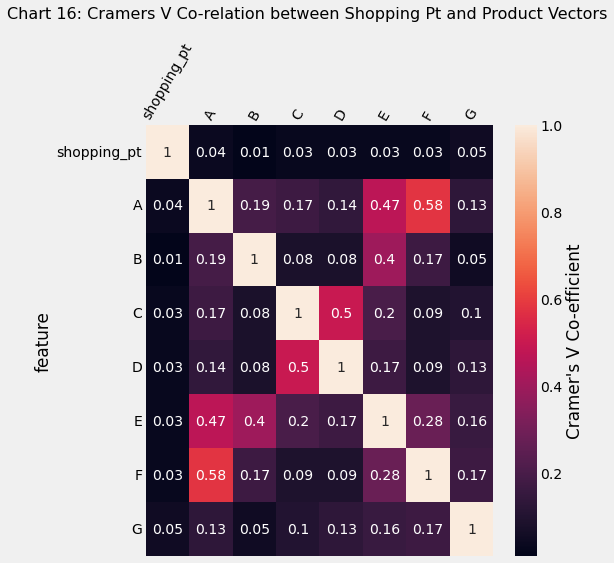

In [120]:
product_vectors = ['A', 'B', 'C','D','E','F','G']

df_vectors_and_shp_pt = df_train[['shopping_pt']+product_vectors]

catg_correlations = cramers_v_df(df_vectors_and_shp_pt)
    
fig, ax = plt.subplots(figsize=(8,8))
ax=sns.heatmap(catg_correlations, annot=True, cbar_kws={"label": "Cramer's V Co-efficient"})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=60)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Chart 16: Cramers V Co-relation between Shopping Pt and Product Vectors", fontsize=16)
plt.tight_layout()
plt.show()
    #file_name = "Chart_"+str(shpng_pt-4)+"_Cramer_V_corelation_for_shopping_point_"+str(shpng_pt)+".jpg"
    #fig.savefig(file_name)

shopping_pt has very little co-relation with any of the product vectors so it can be dropped. Let's check the other numerical variables and their co-relations with product vectors.


## 2.5.2 Other numerical variables<a id='2.5.2_Other_numerical_variables'></a>

Let's look at other numerical variables, specifically their distribution and their co-relations with product vectors.


In [127]:

numeric_features = ['car_age', 'age_youngest', 'age_oldest', 'duration_previous', 'cost']

df_train[numeric_features].describe()

,car_age,age_youngest,age_oldest,duration_previous,cost
count,77607.000000,77607.000000,77607.000000,77607.000000,77607.000000
mean,8.182084,42.687245,45.177690,6.084173,634.444097
std,5.808527,17.500290,17.406433,4.684030,43.013336
min,0.000000,16.000000,18.000000,0.000000,288.000000
25%,3.000000,26.000000,29.000000,2.000000,605.000000
50%,8.000000,40.000000,44.000000,5.000000,634.000000
75%,12.000000,57.000000,60.000000,9.000000,663.000000
max,85.000000,75.000000,75.000000,15.000000,839.000000


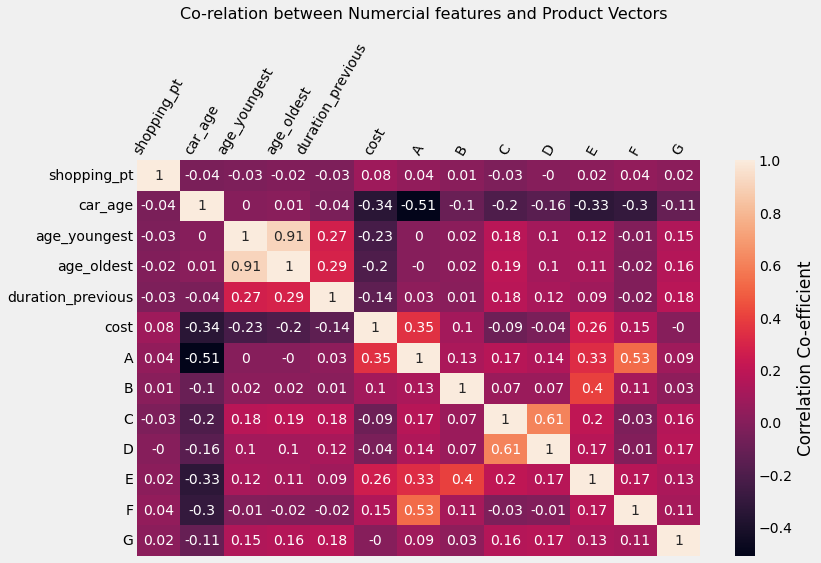

In [89]:
product_vectors = ['A', 'B', 'C','D','E','F','G']
numeric_features = ['shopping_pt', 'car_age', 'age_youngest', 'age_oldest', 'duration_previous', 'cost']
df_vectors_and_num_features = df_train[numeric_features+product_vectors]

    
fig, ax = plt.subplots(figsize=(12,8))
ax=sns.heatmap(np.around(df_vectors_and_num_features.corr(),2), annot=True, cbar_kws={"label": "Correlation Co-efficient"})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=60)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Co-relation between Numercial features and Product Vectors", fontsize=16)
plt.tight_layout()
plt.show()

fig.savefig('charts_EDA/Chart_4_corelation_with_numeric_variables.jpg')


Let's create car_age groupings based on the 4 quartiles of 0-3 years, 3-8 yrs, 8-12 yrs and >12 yrs.
We shall then check the Cramer's co-relation of the car_age group to see if this further enhances the -ve co-relation with vectors A, E and F.



In [182]:
def car_age_grouping(car_age):
    
    if car_age > 12:
        return 0
    elif car_age > 8 and car_age <= 12:
        return 1
    elif car_age > 3 and car_age <= 8:
        return 2
    else:
        return 3
        

In [183]:
df_train['car_age_group'] = df_train['car_age'].apply(car_age_grouping)
df_train['car_age_group'].value_counts()

2    24342
3    19545
1    17614
0    16106
Name: car_age_group, dtype: int64

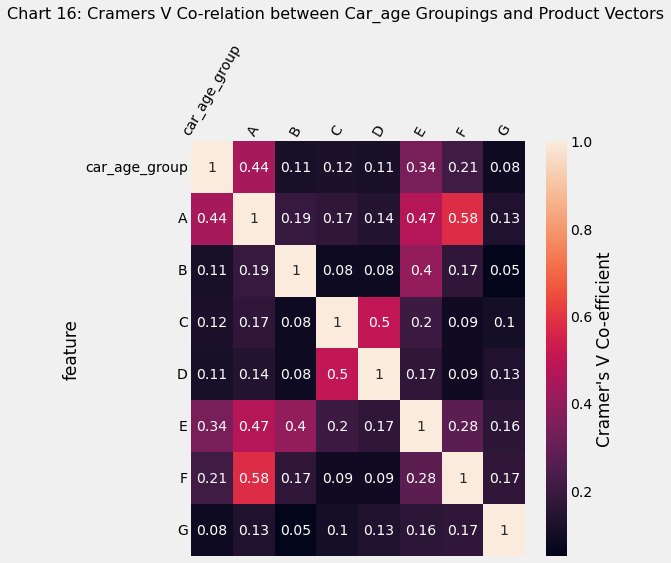

In [184]:



car_age_vect_correlations = cramers_v_df(df_train[['car_age_group']+product_vectors])
    
fig, ax = plt.subplots(figsize=(8,8))
ax=sns.heatmap(car_age_vect_correlations, annot=True, cbar_kws={"label": "Cramer's V Co-efficient"})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=60)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Chart 16: Cramers V Co-relation between Car_age Groupings and Product Vectors", fontsize=16)
plt.tight_layout()
plt.show()

We see above that the creation of car_age groups does not improve the co-relation with vectors A, E or F. As such, we shall take car_age as a numerical variable for modelling.



## 2.5.3 Numerical variables conclusion<a id='2.5.3_Numerical_variables_conclusion'></a>


There seems to be some co-relations (+ve or -ve) between these 5 numerical variables and the product vectors. As such, we shall keep these for modelling and drop shopping_pt.


## 2.6 Product Vectors: Understanding how customers change them <a id='2.6_Product_Vectors'></a>


In this section, we shall explore how customers change product vectors during their shopping journey.

Let's begin by finding what options customers choose for the vector at the start and end of their shopping journey.


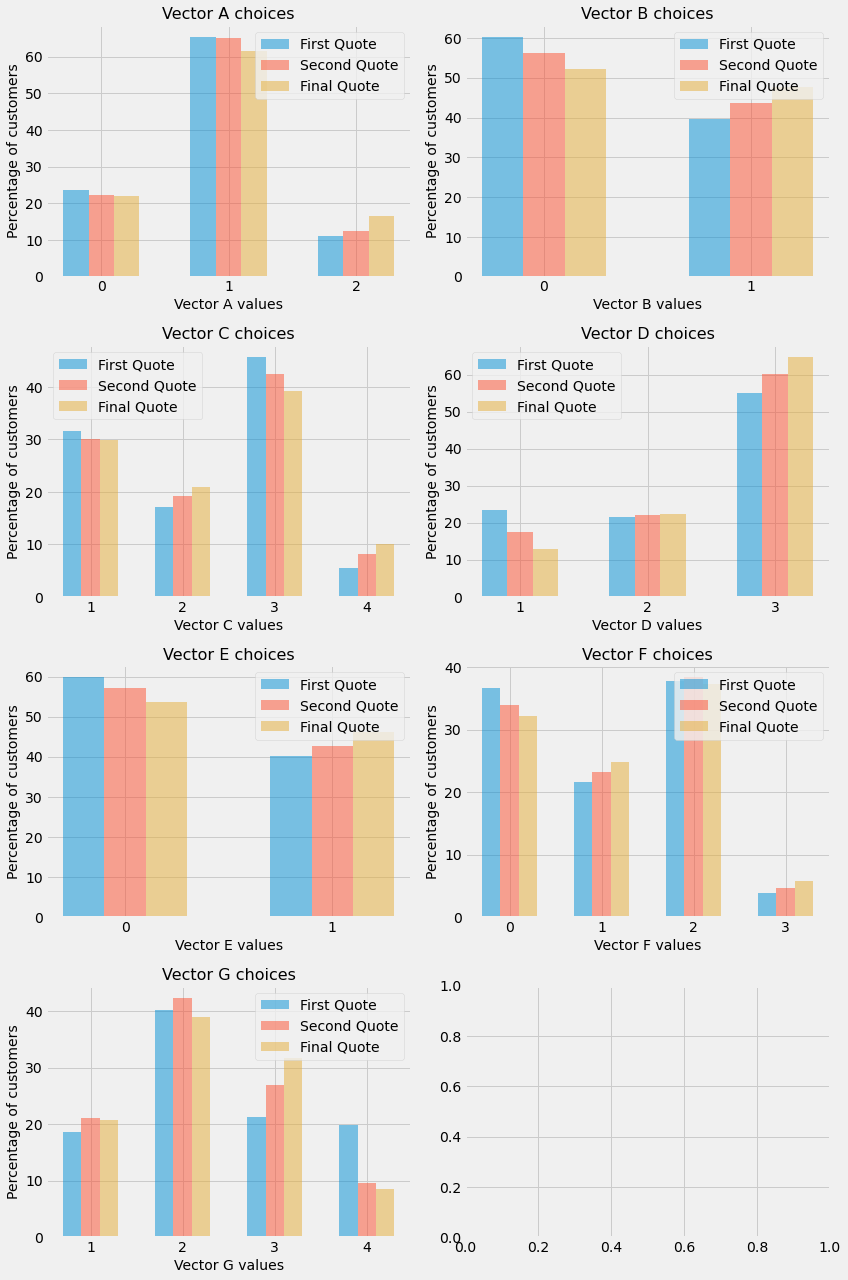

In [57]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(4,2, figsize=(12,18))

product_vectors = ['A', 'B', 'C','D','E','F','G']

for idx, vector in enumerate(product_vectors):
    df_counts = pd.DataFrame({'First Quote': df_train[vector+"_1"].value_counts()*100/df_train.shape[0], \
                              'Second Quote': df_train[vector+"_2"].value_counts()*100/df_train.shape[0], \
                              'Final Quote': df_train[vector].value_counts()*100/df_train.shape[0]})

    width = 0.2                                                                                                  
    ax[idx //2][idx %2].bar(df_counts.index, df_counts['First Quote'], width=width, alpha = 0.5, label='First Quote')
    ax[idx //2][idx %2].bar(df_counts.index+width, df_counts['Second Quote'], width=width, alpha = 0.5, label='Second Quote')
    ax[idx //2][idx %2].bar(df_counts.index+width*2, df_counts['Final Quote'], width=width, alpha = 0.5, label='Final Quote')
    
    #ax.plot(quotes, count_changes[vector], label='vector_'+vector)
    ax[idx //2][idx %2].set_xlabel('Vector '+vector +' values', fontsize=14)
    ax[idx //2][idx %2].set_xticks(df_counts.index+width)
    ax[idx //2][idx %2].set_xticklabels(list(map(str, df_counts.index)), fontsize=14)
    ax[idx //2][idx %2].set_ylabel('Percentage of customers', fontsize=14)
    
    
    ax[idx //2][idx %2].set_title('Vector '+vector+ ' choices', fontsize=16)
    ax[idx //2][idx %2].legend()

plt.tight_layout()
plt.show()

#fig.savefig('Chart_1_vector_changes.jpg')

In [149]:
vector = 'G'

df_counts = pd.DataFrame({'First Quote': df_train[vector+"_1"].value_counts()*100/df_train.shape[0], \
                              'Second Quote': df_train[vector+"_2"].value_counts()*100/df_train.shape[0], \
                              'Final Quote': df_train[vector].value_counts()*100/df_train.shape[0]})
df_counts = df_counts.T
df_counts

,1,2,3,4
First Quote,18.656822,40.121381,21.312510,19.909287
Second Quote,21.098612,42.344118,26.875153,9.682116
Final Quote,20.753283,38.988751,31.770330,8.487636


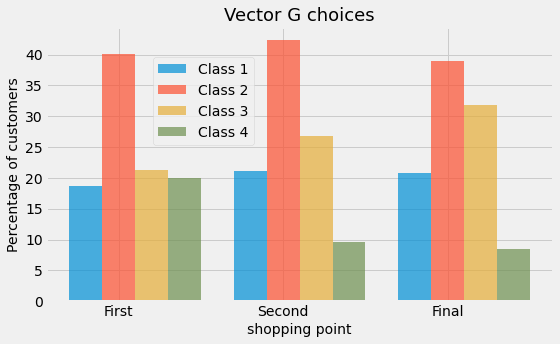

In [154]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(1,1, figsize=(8,5))

vector = 'G'

df_counts = pd.DataFrame({'First Quote': df_train[vector+"_1"].value_counts()*100/df_train.shape[0], \
                              'Second Quote': df_train[vector+"_2"].value_counts()*100/df_train.shape[0], \
                              'Final Quote': df_train[vector].value_counts()*100/df_train.shape[0]})
df_counts = df_counts.T

width = 0.2
ticks  = [x for x in range(0,3)]

ax.bar(ticks, df_counts[1], width=width, alpha = 0.7, label='Class 1')
ax.bar([x+width for x in ticks], df_counts[2], width=width, alpha = 0.7, label='Class 2')
ax.bar([x+2*width for x in ticks], df_counts[3], width=width, alpha = 0.7, label='Class 3')
ax.bar([x+3*width for x in ticks], df_counts[4], width=width, alpha = 0.7, label='Class 4')

    #ax.plot(quotes, count_changes[vector], label='vector_'+vector)
ax.set_xlabel('shopping point', fontsize=14)
ax.set_xticks([x+width for x in ticks])
ax.set_xticklabels(['First', 'Second', 'Final'], fontsize=14)
ax.set_ylabel('Percentage of customers', fontsize=14)

ax.set_title('Vector '+vector+ ' choices', fontsize=18)
axbox = ax.get_position()

ax.legend(loc = (axbox.x0+0.13, axbox.y0+0.5))


plt.tight_layout()
plt.show()

fig.savefig('charts_EDA/Chart_5_vector_G_choices_ver2.jpg')

In [58]:
# Let's find out how many changes are made to different vectors from quote 2 through to 13

product_vectors = ['A', 'B', 'C','D','E','F','G']

changes_tracker = {}

for vector in product_vectors:
    changes_tracker[vector] = []
    
    for quote in range(2,14):
        # filter vector columns for current quote and previous quote
        cols_to_compare = df_train[[vector+'_'+str(quote), vector+'_'+str(quote-1)]].dropna(axis=0)
        
        # count how many customers changed vector from previous quote to current quote
        changes_tracker[vector].append(np.sum(np.where(cols_to_compare[vector+'_'+str(quote)] \
                                                       != cols_to_compare[vector+'_'+str(quote-1)], 1, 0)))
        
        

count_changes = pd.DataFrame(changes_tracker)


In [59]:
count_changes['total'] = count_changes.sum(axis=1)
count_changes

,A,B,C,D,E,F,G,total
0,16995,11547,19365,14190,12789,17807,21633,114326
1,7373,5497,8235,5844,5937,7700,9219,49805
2,4158,2918,3980,2788,3105,4133,6498,27580
3,3018,2034,2733,1761,2163,2955,5137,19801
4,2411,1747,2197,1403,1760,2345,4383,16246
5,1831,1303,1689,1083,1266,1712,3558,12442
6,1255,956,1228,797,995,1206,2486,8923
7,711,602,696,505,593,670,1363,5140
8,322,263,312,219,236,303,680,2335
9,86,86,106,84,64,97,197,720


In [103]:
def vect_change_tracker(vector):
    changes_tracker = {}
    cust_tracker = df_train[['customer_ID', 'shopping_pt']]

    for quote in range(2,14):
        cols_to_select = ['customer_ID']
    
        
        cols_to_select.append(vector+"_"+str(quote))
        cols_to_select.append(vector+"_"+str(quote-1))
        
        cols_to_compare = df_train[df_train['shopping_pt'] >= quote][cols_to_select]
           
        # tag which customers changed vector from previous quote to current quote
        cols_to_compare[vector+"_changed_at_"+str(quote)] = np.where(cols_to_compare[vector+'_'+str(quote)] \
                                                       != cols_to_compare[vector+'_'+str(quote-1)], 1, 0)
        
        cust_tracker = cust_tracker.merge(cols_to_compare[['customer_ID', vector+"_changed_at_"+str(quote)]], on = 'customer_ID', how='left')
    
    return cust_tracker



In [163]:
# function to plot the distribution of changes in a vector
def vector_change_plot(vector):
    
    vect_changes = vect_change_tracker(vector)
    vect_changes['total_changes'] = vect_changes.iloc[:, 2:].sum(axis=1)
    mean_changes = np.around(np.mean(vect_changes['total_changes']),2)
    count_cust_changing_vector = np.sum(vect_changes['total_changes']!= 0)
    mean_changes_per_cust_who_change_vector = np.around(vect_changes['total_changes'].sum() / count_cust_changing_vector, 2)

    print(f'Total customers = {vect_changes.shape[0]}, Avg. Changes per customer to vector {vector}: {mean_changes}')

    print(f'No. of customers changing vector {vector} = {count_cust_changing_vector}, \
    avg. changes per changing customer to vector {vector}: {mean_changes_per_cust_who_change_vector}')

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].boxplot(vect_changes['total_changes'])
    ax[0].set_ylabel('Total changes made by customers to vector '+vector)
    ax[0].set_xticklabels(['All customers across all quotes'])

    ax[1].hist(vect_changes['total_changes'], density = True, bins=np.unique(vect_changes['total_changes']))
    ax[1].set_ylabel('Proportion of customers')
    ax[1].set_xlabel('Total changes to vector '+vector)
    ax[1].axvline(mean_changes, color='green', linestyle="--", label='Mean = '+str(mean_changes))


    ax[1].annotate('Total Customers = '+str(vect_changes.shape[0]), xy=(1, 0.5),  xycoords='data', xytext=(0.8, 0.8), \
            textcoords='axes fraction', horizontalalignment='center', verticalalignment='top')

    text_1 = 'Customers changing vector '+vector+' = '+str(count_cust_changing_vector)
    ax[1].annotate(text_1, xy=(1, 0.5),  xycoords='data', xytext=(0.65, 0.73), \
            textcoords='axes fraction', horizontalalignment='center', verticalalignment='top')

    text_2 = 'Avg. changes per changing customer = '+str(mean_changes_per_cust_who_change_vector)
    ax[1].annotate(text_2, xy=(1, 0.5),  xycoords='data', xytext=(0.65, 0.66), \
            textcoords='axes fraction', horizontalalignment='center', verticalalignment='top')

    plt.suptitle('Distribution of changes made by customers to vector '+vector, fontsize=18)
    plt.legend()
    plt.tight_layout()
    plt.show()
    filename = 'charts_EDA/Distribution_of_changes_to_vector_'+vector+'.jpg'
    fig.savefig(filename)


Total customers = 77607, Avg. Changes per customer to vector A: 0.49
No. of customers changing vector A = 30468,     avg. changes per changing customer to vector A: 1.25


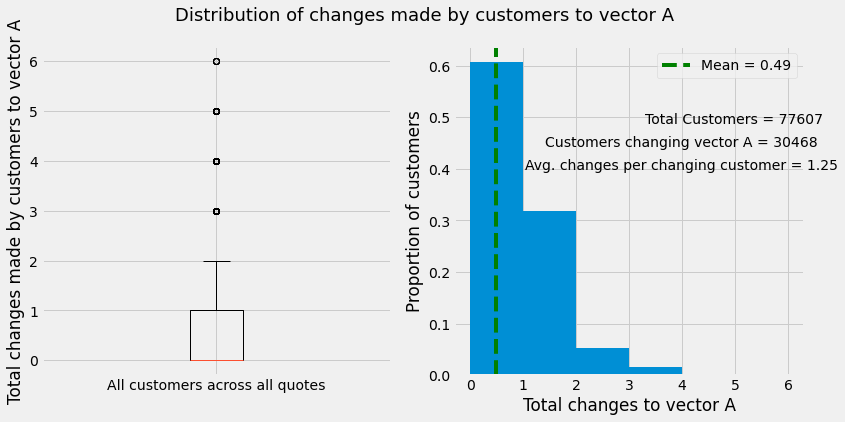

In [164]:
vector_change_plot('A')


Total customers = 77607, Avg. Changes per customer to vector G: 0.71
No. of customers changing vector G = 39506,     avg. changes per changing customer to vector G: 1.4


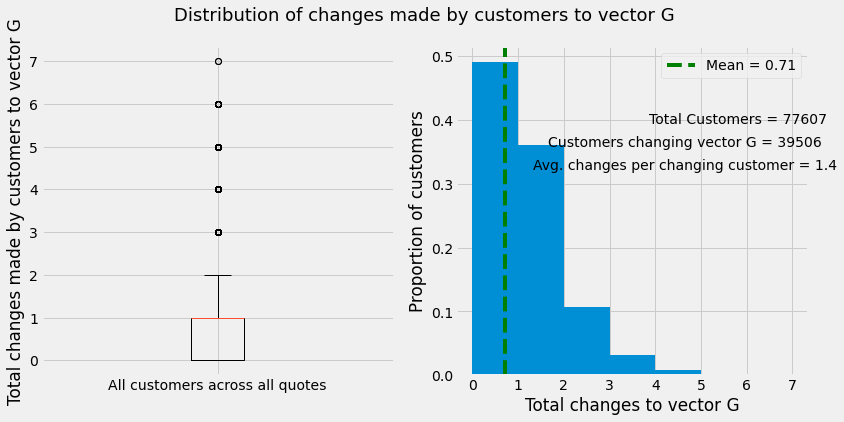

In [165]:
# Understanding distribution of changes to vector G
vector_change_plot('G')

Total customers = 77607, Avg. Changes per customer to vector B: 0.35
No. of customers changing vector B = 24096,     avg. changes per changing customer to vector B: 1.12


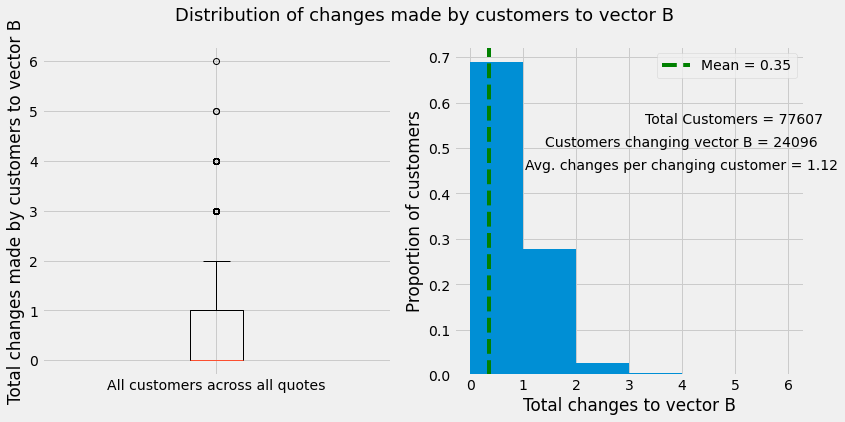

In [166]:
vector_change_plot('B')


In [60]:
# Here, we count all changes (across the 7 vectors)  made by each customer at every shopping pt

product_vectors = ['A', 'B', 'C','D','E','F','G']

changes_tracker = {}
cust_tracker = df_train[['customer_ID', 'shopping_pt']]

for quote in range(2,14):
    cols_to_select = ['customer_ID']
    
    for vector in product_vectors:
        cols_to_select.append(vector+"_"+str(quote))
        cols_to_select.append(vector+"_"+str(quote-1))
        
    cols_to_compare = df_train[df_train['shopping_pt'] >= quote][cols_to_select]
    
    cols_to_sum = []

    for vector in product_vectors:
    
        # count how many customers changed vector from previous quote to current quote
        cols_to_compare[str(quote)+vector] = np.where(cols_to_compare[vector+'_'+str(quote)] \
                                                       != cols_to_compare[vector+'_'+str(quote-1)], 1, 0)
        
        cols_to_sum.append(str(quote)+vector)
        
    cols_to_compare[str(quote)+'_changes'] = cols_to_compare[cols_to_sum].sum(axis=1)
    
    cust_tracker = cust_tracker.merge(cols_to_compare[['customer_ID', str(quote)+'_changes']], on = 'customer_ID', how='left')
   

In [76]:
cust_tracker.sample(5)

,customer_ID,shopping_pt,2_changes,3_changes,4_changes,5_changes,6_changes,7_changes,8_changes,9_changes,10_changes,11_changes,12_changes,13_changes
6820,10039760,7,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
27365,10134262,5,3,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23920,10093508,7,1,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
24285,10115416,4,4,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20163,10077730,8,6,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [62]:
active_and_changing = pd.DataFrame({"shopping_pt": [x for x in range(2,14)], "active_customers": cust_tracker.iloc[:, 2:14].count(axis=0)})
active_and_changing["customers_with_changes"] = (cust_tracker.fillna(0).iloc[:, 2:14] != 0).sum(axis=0)
active_and_changing = active_and_changing.reset_index()
active_and_changing = active_and_changing.drop(columns="index")
#active_and_changing = active_and_changing.set_index("shopping_pt")
active_and_changing["%_with_changes"] = np.round(active_and_changing["customers_with_changes"] *100 / active_and_changing["active_customers"], 2)

active_and_changing

,shopping_pt,active_customers,customers_with_changes,%_with_changes
0,2,77607,46471,59.88
1,3,77607,25361,32.68
2,4,73152,16676,22.80
3,5,66751,12840,19.24
4,6,57736,10679,18.50
5,7,45238,8275,18.29
6,8,30366,5769,19.00
7,9,16568,3263,19.69
8,10,6980,1488,21.32
9,11,2123,470,22.14


In [63]:
active_and_changing = active_and_changing.merge(count_changes, left_index=True, right_index=True, how='left')
for vector in product_vectors:
    active_and_changing['%cust_'+vector+'_change'] = np.around(active_and_changing[vector] *100 / active_and_changing["active_customers"], 2)
active_and_changing

,shopping_pt,active_customers,customers_with_changes,%_with_changes,A,B,C,D,E,F,G,total,%cust_A_change,%cust_B_change,%cust_C_change,%cust_D_change,%cust_E_change,%cust_F_change,%cust_G_change
0,2,77607,46471,59.88,16995,11547,19365,14190,12789,17807,21633,114326,21.90,14.88,24.95,18.28,16.48,22.95,27.88
1,3,77607,25361,32.68,7373,5497,8235,5844,5937,7700,9219,49805,9.50,7.08,10.61,7.53,7.65,9.92,11.88
2,4,73152,16676,22.80,4158,2918,3980,2788,3105,4133,6498,27580,5.68,3.99,5.44,3.81,4.24,5.65,8.88
3,5,66751,12840,19.24,3018,2034,2733,1761,2163,2955,5137,19801,4.52,3.05,4.09,2.64,3.24,4.43,7.70
4,6,57736,10679,18.50,2411,1747,2197,1403,1760,2345,4383,16246,4.18,3.03,3.81,2.43,3.05,4.06,7.59
5,7,45238,8275,18.29,1831,1303,1689,1083,1266,1712,3558,12442,4.05,2.88,3.73,2.39,2.80,3.78,7.87
6,8,30366,5769,19.00,1255,956,1228,797,995,1206,2486,8923,4.13,3.15,4.04,2.62,3.28,3.97,8.19
7,9,16568,3263,19.69,711,602,696,505,593,670,1363,5140,4.29,3.63,4.20,3.05,3.58,4.04,8.23
8,10,6980,1488,21.32,322,263,312,219,236,303,680,2335,4.61,3.77,4.47,3.14,3.38,4.34,9.74
9,11,2123,470,22.14,86,86,106,84,64,97,197,720,4.05,4.05,4.99,3.96,3.01,4.57,9.28


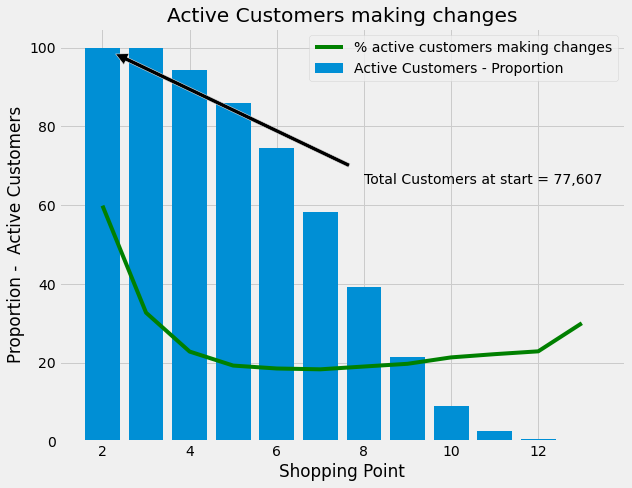

In [90]:
fig, ax = plt.subplots(1,1, figsize = (9,7))

ax.bar(active_and_changing.shopping_pt, active_and_changing["active_customers"]*100/df_train.shape[0], label = 'Active Customers - Proportion')
ax.set_ylabel("Proportion -  Active Customers")
ax.set_xlabel("Shopping Point")
ax.set_title("Active Customers making changes")
ax.annotate('Total Customers at start = 77,607', xy=(2, 100),  xycoords='data', xytext=(0.75, 0.65), \
            textcoords='axes fraction', arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='center', \
            verticalalignment='top')

ax.plot(active_and_changing.shopping_pt, active_and_changing["%_with_changes"], color='green', label = '% active customers making changes')
ax.legend()
plt.tight_layout()
plt.show()

fig.savefig('charts_EDA/Chart_7_active_customers_making_changes.jpg')

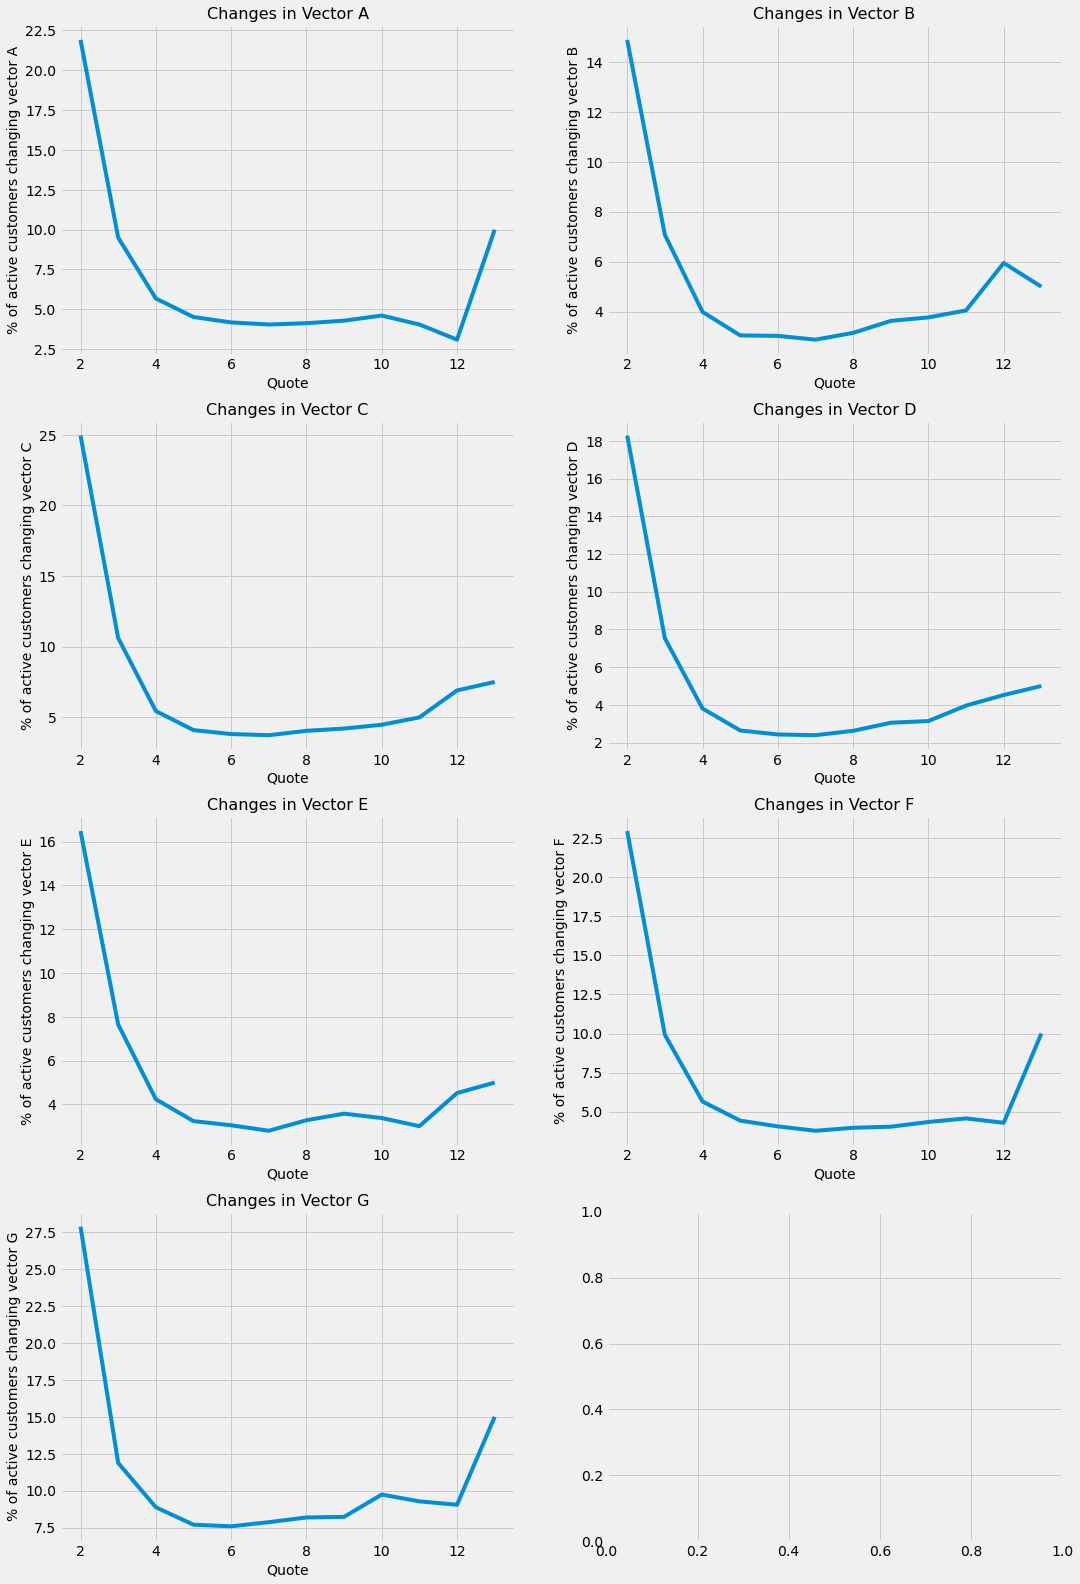

In [170]:


plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(4,2, figsize=(16,26))

for idx, vector in enumerate(product_vectors):
    ax[idx // 2][idx % 2].plot(active_and_changing.shopping_pt, active_and_changing['%cust_'+vector+'_change'])
    ax[idx // 2][idx % 2].set_xlabel('Quote', fontsize=14)
    ax[idx // 2][idx % 2].set_ylabel('% of active customers changing vector '+vector, fontsize=14)
    ax[idx // 2][idx % 2].set_title('Changes in Vector '+vector, fontsize=16)

plt.show()


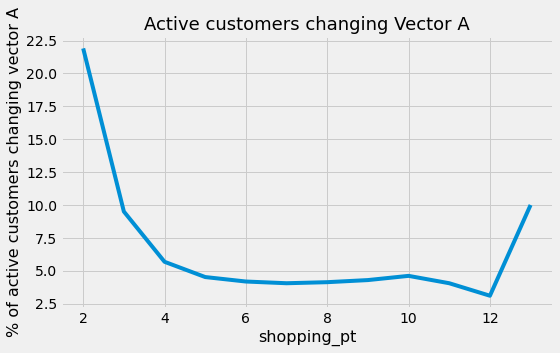

In [66]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1,1, figsize=(8,5))
vector = 'A'

ax.plot(active_and_changing.shopping_pt, active_and_changing['%cust_'+vector+'_change'])
ax.set_xlabel('shopping_pt', fontsize=16)
ax.set_ylabel('% of active customers changing vector '+vector, fontsize=16)
ax.set_title('Active customers changing Vector '+vector, fontsize=18)
plt.tight_layout()

plt.show()
fig.savefig('charts_EDA/Chart_6_vector_A_changes_by_shopping_pt.jpg')


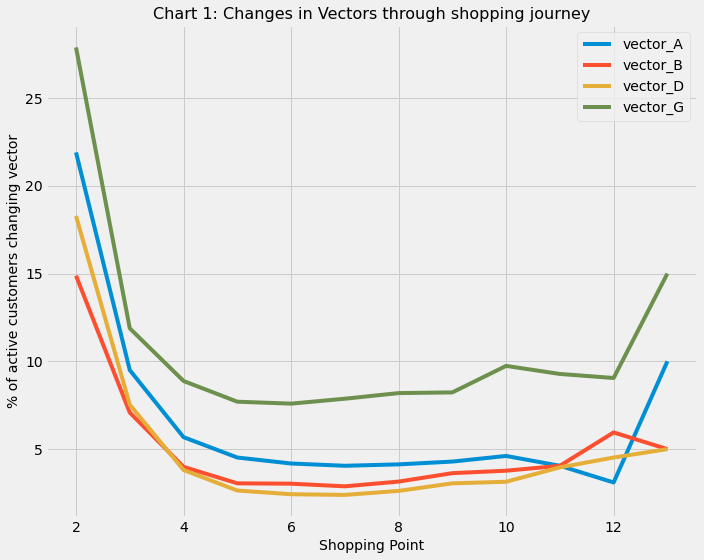

In [196]:

fig, ax = plt.subplots(figsize=(10,8))

p_vectors = ['A', 'B', 'D','G']

for idx, vector in enumerate(p_vectors):
    ax.plot(active_and_changing.shopping_pt, active_and_changing['%cust_'+vector+'_change'], label='vector_'+vector)
    ax.set_xlabel('Shopping Point', fontsize=14)
    ax.set_ylabel('% of active customers changing vector', fontsize=14)
    
    ax.set_title('Chart 1: Changes in Vectors through shopping journey', fontsize=16)
    
ax.legend()
plt.tight_layout()
plt.show()

#fig.savefig('Chart_1_vector_changes.jpg')


The above charts for no. of customers making changes at each quote seems to resemble an exponential decay. 
While the no. of customers making changes declines rapidly as they move further in the quote process, the absolute nos. of customers making changes is still in thousands till quotes 8 and 9, so not totally ignorable. 

Let's now get a sense of how many vectors (out of the 7 product vectors) do customers change on average during their shopping journey.


In [77]:

change_cols = ['2_changes', '3_changes', '4_changes','5_changes', '6_changes', '7_changes', '8_changes',\
               '9_changes', '10_changes','11_changes', '12_changes', '13_changes']

cust_tracker['total_changes'] = cust_tracker[change_cols].sum(axis=1)

#avg_changes_per_customer = np.mean(cust_tracker_2['total_changes'])

print('Avg. Changes per customer:', round(np.mean(cust_tracker['total_changes']),2))
print('Standard deviation of changes per customer:', round(np.std(cust_tracker['total_changes']),2))
print('Median Changes per customer:', np.median(cust_tracker['total_changes']))


Avg. Changes per customer: 3.32
Standard deviation of changes per customer: 2.64
Median Changes per customer: 3.0


So on an average, each customer makes 3 changes in the product vectors during their shopping journey. 

Now let's see how these changes are distributed across the shopping journey.

First, one important definition. 

**Active Customer**: We define active customer as a customer who is still shopping and has not purchased a policy yet.

In the following few charts, we explore at each shopping point:

a) What proportion of active customers are making changes 

b) The distribution of the no. of changes at each stage (if a customer changes two vectors at a single shopping point, we shall count that as 2 changes)



Above chart shows that active customers start declining after shopping point 3 onwards that means customers start purchasing the policy from shopping point 3.

The % of customers who make changes at shopping point 2 is really high at around 60%. This declines rapidly thereafter. Shopping 5 onwards a little less than 20% of active customers make changes. After shopping point 9, the % customers making changes again creeps up as the no. of active customers drops substantially.

Now let's visualize the distribution of total changes made by customers using a boxplot and histogram.


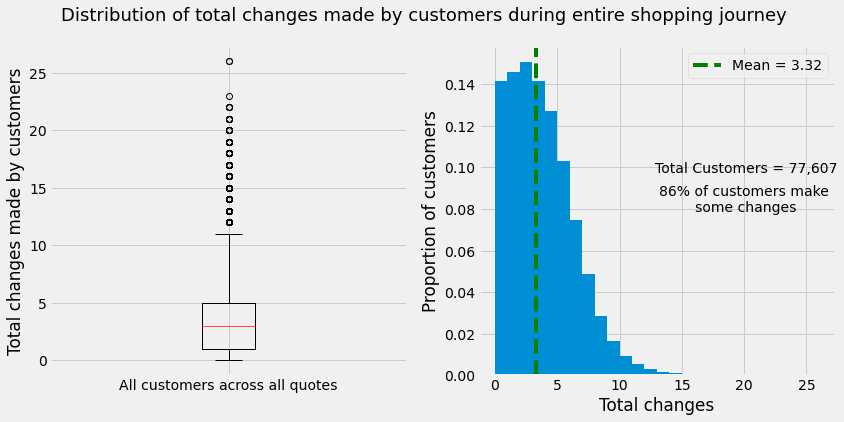

In [124]:

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].boxplot(cust_tracker['total_changes'])
ax[0].set_ylabel('Total changes made by customers')
ax[0].set_xticklabels(['All customers across all quotes'])
ax[1].hist(cust_tracker['total_changes'], density = True, bins=np.unique(cust_tracker['total_changes']))
ax[1].set_ylabel('Proportion of customers')
ax[1].set_xlabel('Total changes')
ax[1].axvline(3.32, color='green', linestyle="--", label='Mean = 3.32')

ax[1].annotate('Total Customers = 77,607', xy=(1, 0.1),  xycoords='data', xytext=(0.75, 0.65), \
            textcoords='axes fraction', horizontalalignment='center', verticalalignment='top')

ax[1].annotate('86% of customers make \nsome changes', xy=(1, 0.1),  xycoords='data', xytext=(0.75, 0.58), \
            textcoords='axes fraction', horizontalalignment='center', verticalalignment='top')

plt.suptitle('Distribution of total changes made by customers during entire shopping journey', fontsize=18)
plt.legend()
plt.tight_layout()
plt.show()

fig.savefig('charts_EDA/Distribution_of_total_changes.jpg')


From the above boxplot and histogram, we observe that:
* The IQR of total changes is between 1 and 5 i.e. the middle 50% customers make between 1 to 5 changes across their shopping journey. 
* The distribution is right-tailed, no. of customers making higher changes continuously drops.
* There are more than 10,000 out of the 77,000 customers who don't make any changes throughout their shopping journey!
* At the same time, there are many outliers- quite a few customers who make more than 11 changes while they are shopping. Some make as many as 25+ changes!

We saw earlier that changes are front loaded i.e. lot of customers make them early on in the quote process. Let's check out the distribution of changes across each quote using box plots. 


In [222]:
cust_tracker.iloc[:, 13].dropna().value_counts()

0.0    28
2.0     6
1.0     4
4.0     1
3.0     1
Name: 13_changes, dtype: int64

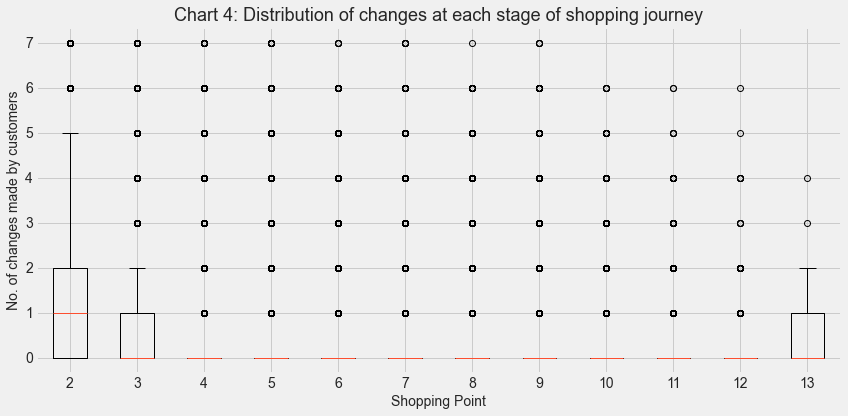

In [246]:
fig, ax = plt.subplots(figsize=(12,6))

ax.boxplot([cust_tracker.iloc[:, quote].dropna() for quote in range(2,14)])

plt.title('Chart 4: Distribution of changes at each stage of shopping journey', fontsize=18)
plt.ylabel('No. of changes made by customers', fontsize= 14)
plt.xticks(np.arange(1,13), labels = [x for x in range(2,14)])
plt.xlabel('Shopping Point', fontsize= 14)
plt.tight_layout()
plt.show()
fig.savefig("Chart_4_Distribution_of_changes_at_each_shopping_point.jpg")


The above boxplots show that quote 2 & 3 are the most active. At quote 2, when lots of customers are making changes, the no. of vectors being changed is 2 or less for 75% of the customers. And from quote 4 onwards, less than 25% of the customers make any changes. At the same time, there are outliers at each stage, some of whom change all 7 vectors!


Let's check if customers who stay longer in the shopping journey make more changes on average. We do this by plotting average no. of changes for customers with different conclusion (purchase) points.


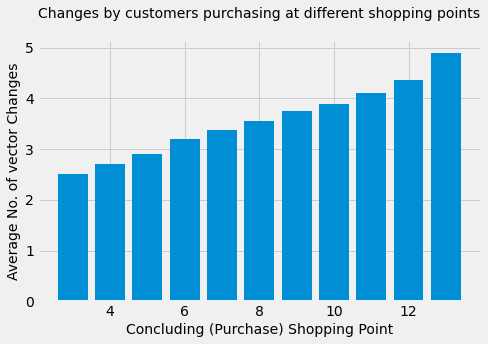

In [94]:
avg_changes = cust_tracker.pivot_table(index='shopping_pt', values='total_changes')

fig, ax = plt.subplots()
fig.set_size_inches([7, 5])

plt.bar(avg_changes.index, avg_changes['total_changes'])
plt.xlabel('Concluding (Purchase) Shopping Point', fontsize=14)
plt.ylabel('Average No. of vector Changes', fontsize=14)
#plt.ylim(0,6)
plt.title('Changes by customers purchasing at different shopping points\n', fontsize=14)

plt.tight_layout()
plt.show()
fig.savefig("Chart_5_Avg_changes_by_purchase_shopping_point.jpg")



So the customers who take longer (more quotes) to purchase the policy make more vector changes on average.

**Key Learnings**
* Most customers make changes early on, at shopping points 2 & 3.
* The average changes made by a customer are around **3**.
* There are many outlier customers who make lots of changes, some as many at 20+!
* While the % of active customers making changes drops, it stays in the 18- 20% range from stage 5 onwards.




In [93]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def cramers_v_df(dataframe):
    cols = dataframe.columns
    crm_v_matrix = {'feature': cols}
    for col1 in cols:
        crm_v_matrix[col1] = []
        for col2 in cols:
            crm_v_matrix[col1].append(round(cramers_v(dataframe[col1], dataframe[col2]),3))
     
    return pd.DataFrame(crm_v_matrix).set_index('feature')
            

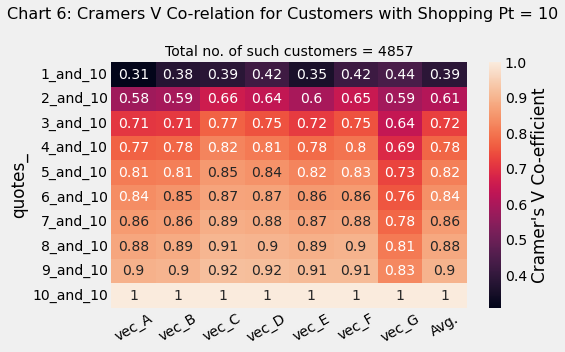

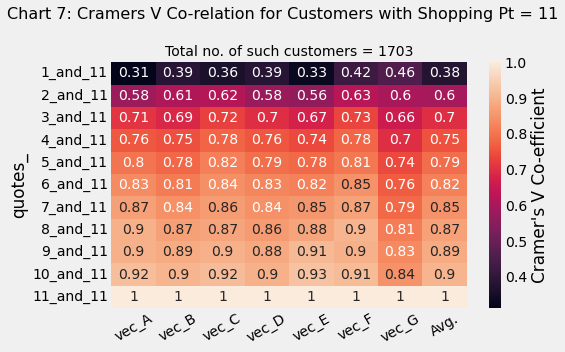

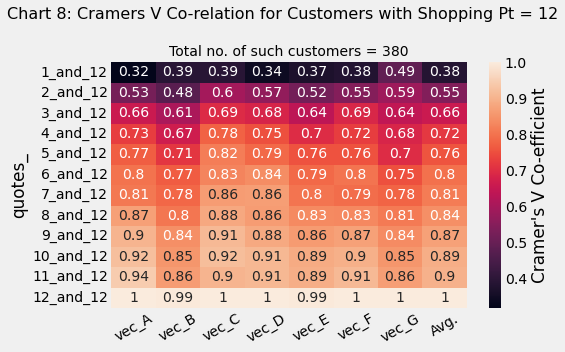

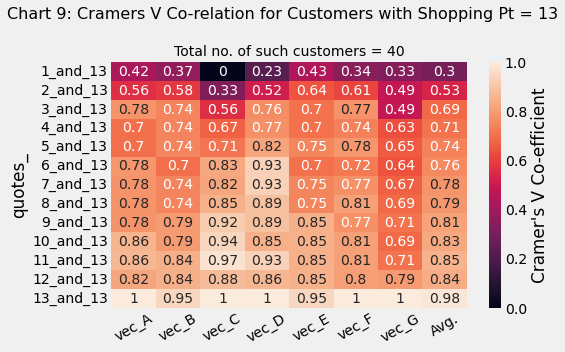

In [95]:

cust_10qplus = df_train[df_train['shopping_pt'] >= 10]
product_vectors = ['A', 'B', 'C','D','E','F','G']


for shpng_pt in range(10,14):
    crm_v = {}
    df_temp = cust_10qplus[cust_10qplus['shopping_pt'] == shpng_pt]
    
    crm_v['quotes_'] = [str(x)+"_and_"+str(shpng_pt) for x in range(1,shpng_pt+1)]
    
    for vector in product_vectors:
        crm_v['vec_'+vector] = []
        
        for quote in range(1, shpng_pt+1):
            crm_v['vec_'+vector].append(round(cramers_v(df_temp[vector+"_"+str(quote)], df_temp[vector]),3))
            
    
    crm_coeff = pd.DataFrame(crm_v)
    crm_coeff = crm_coeff.set_index('quotes_')
    crm_coeff['Avg.'] = round(crm_coeff.sum(axis = 1) / 7, 3)
    
    #print(f'\nCramers V Co-relation for Customers with Shopping Pt = {shpng_pt}')
    #print(f'\nNumber of customers = {df_temp.shape[0]}')
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax=sns.heatmap(crm_coeff, annot=True, cbar_kws={"label": "Cramer's V Co-efficient"})
    plt.xticks(fontsize="14", rotation=30)
    plt.suptitle("Chart "+str(shpng_pt-4)+": Cramers V Co-relation for Customers with Shopping Pt = %d" %shpng_pt, fontsize=16)
    plt.title("Total no. of such customers = %d" %df_temp.shape[0], fontsize=14)
    plt.tight_layout()
    plt.show()
    #file_name = "Chart_"+str(shpng_pt-4)+"_Cramer_V_corelation_for_shopping_point_"+str(shpng_pt)+".jpg"
    #fig.savefig(file_name)
    





## 2.7 Summary<a id='2.7_Summary'></a>


During the EDA stage, all independent variables were looked at in depth to understand their characteristics and how they seems to interact with the target vectors. A statistical approach was used to test whether differences amongst various classes in each categorical variable are significant or not.

The following are the key outcomes based on the work in this stage:

1) Based on observed correlations, it was deemed appropriate to drop some of the variables from model development. These variables are 'day', 'time', 'shopping_pt' and 'location'.

2) Strategy to impute missing values: For each variable with missing values, an imputation strategy was outlined.

    a) C_previous: Most frequent class (3)
    b) duration_previous: Median
    c) car_value: Median

3) Dealing with numerical variables: As the variables have very different values and spread, they would have to be scaled before fitting the model.

4) Learnings from how customers change product vectors(features):
* Most customers make changes early on, at shopping points 2 & 3.
* The average changes made by a customer are around **3**.
* There are many outlier customers who make lots of changes, some as many at 20+!
* While the % of active customers making changes drops, it stays in the 18- 20% range from stage 5 onwards.


